In [2]:
import torch as tch
import numpy as np
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
import os

import loader
import DataTools
import Networks
import parameters

In [ ]:
model = Networks.ECG_SpatioTemporalNet(**parameters.spatioTemporalParams_v4, mlp=False)
optimizer = tch.optim.Adam(model.parameters(), lr=1e-4)
# print(model.firstLayer.parameters())
# print(model.residualBlocks_time.parameters())
# print(model.residualBlocks_space.parameters())
# print(model.integrationBlock.parameters())
# print(model.finalLayer.parameters())
print(optimizer)
for i,x in model.named_children():
    print(i)
    # print(model.i)
params = [{
    'params':getattr(model,i).parameters(), 'lr': 1e-5} if i.find("finalLayer")==-1 else {'params':getattr(model,i).parameters(), 'lr': 1e-3} for i,x in model.named_children()]

optimizer = tch.optim.Adam(params)

print(params)



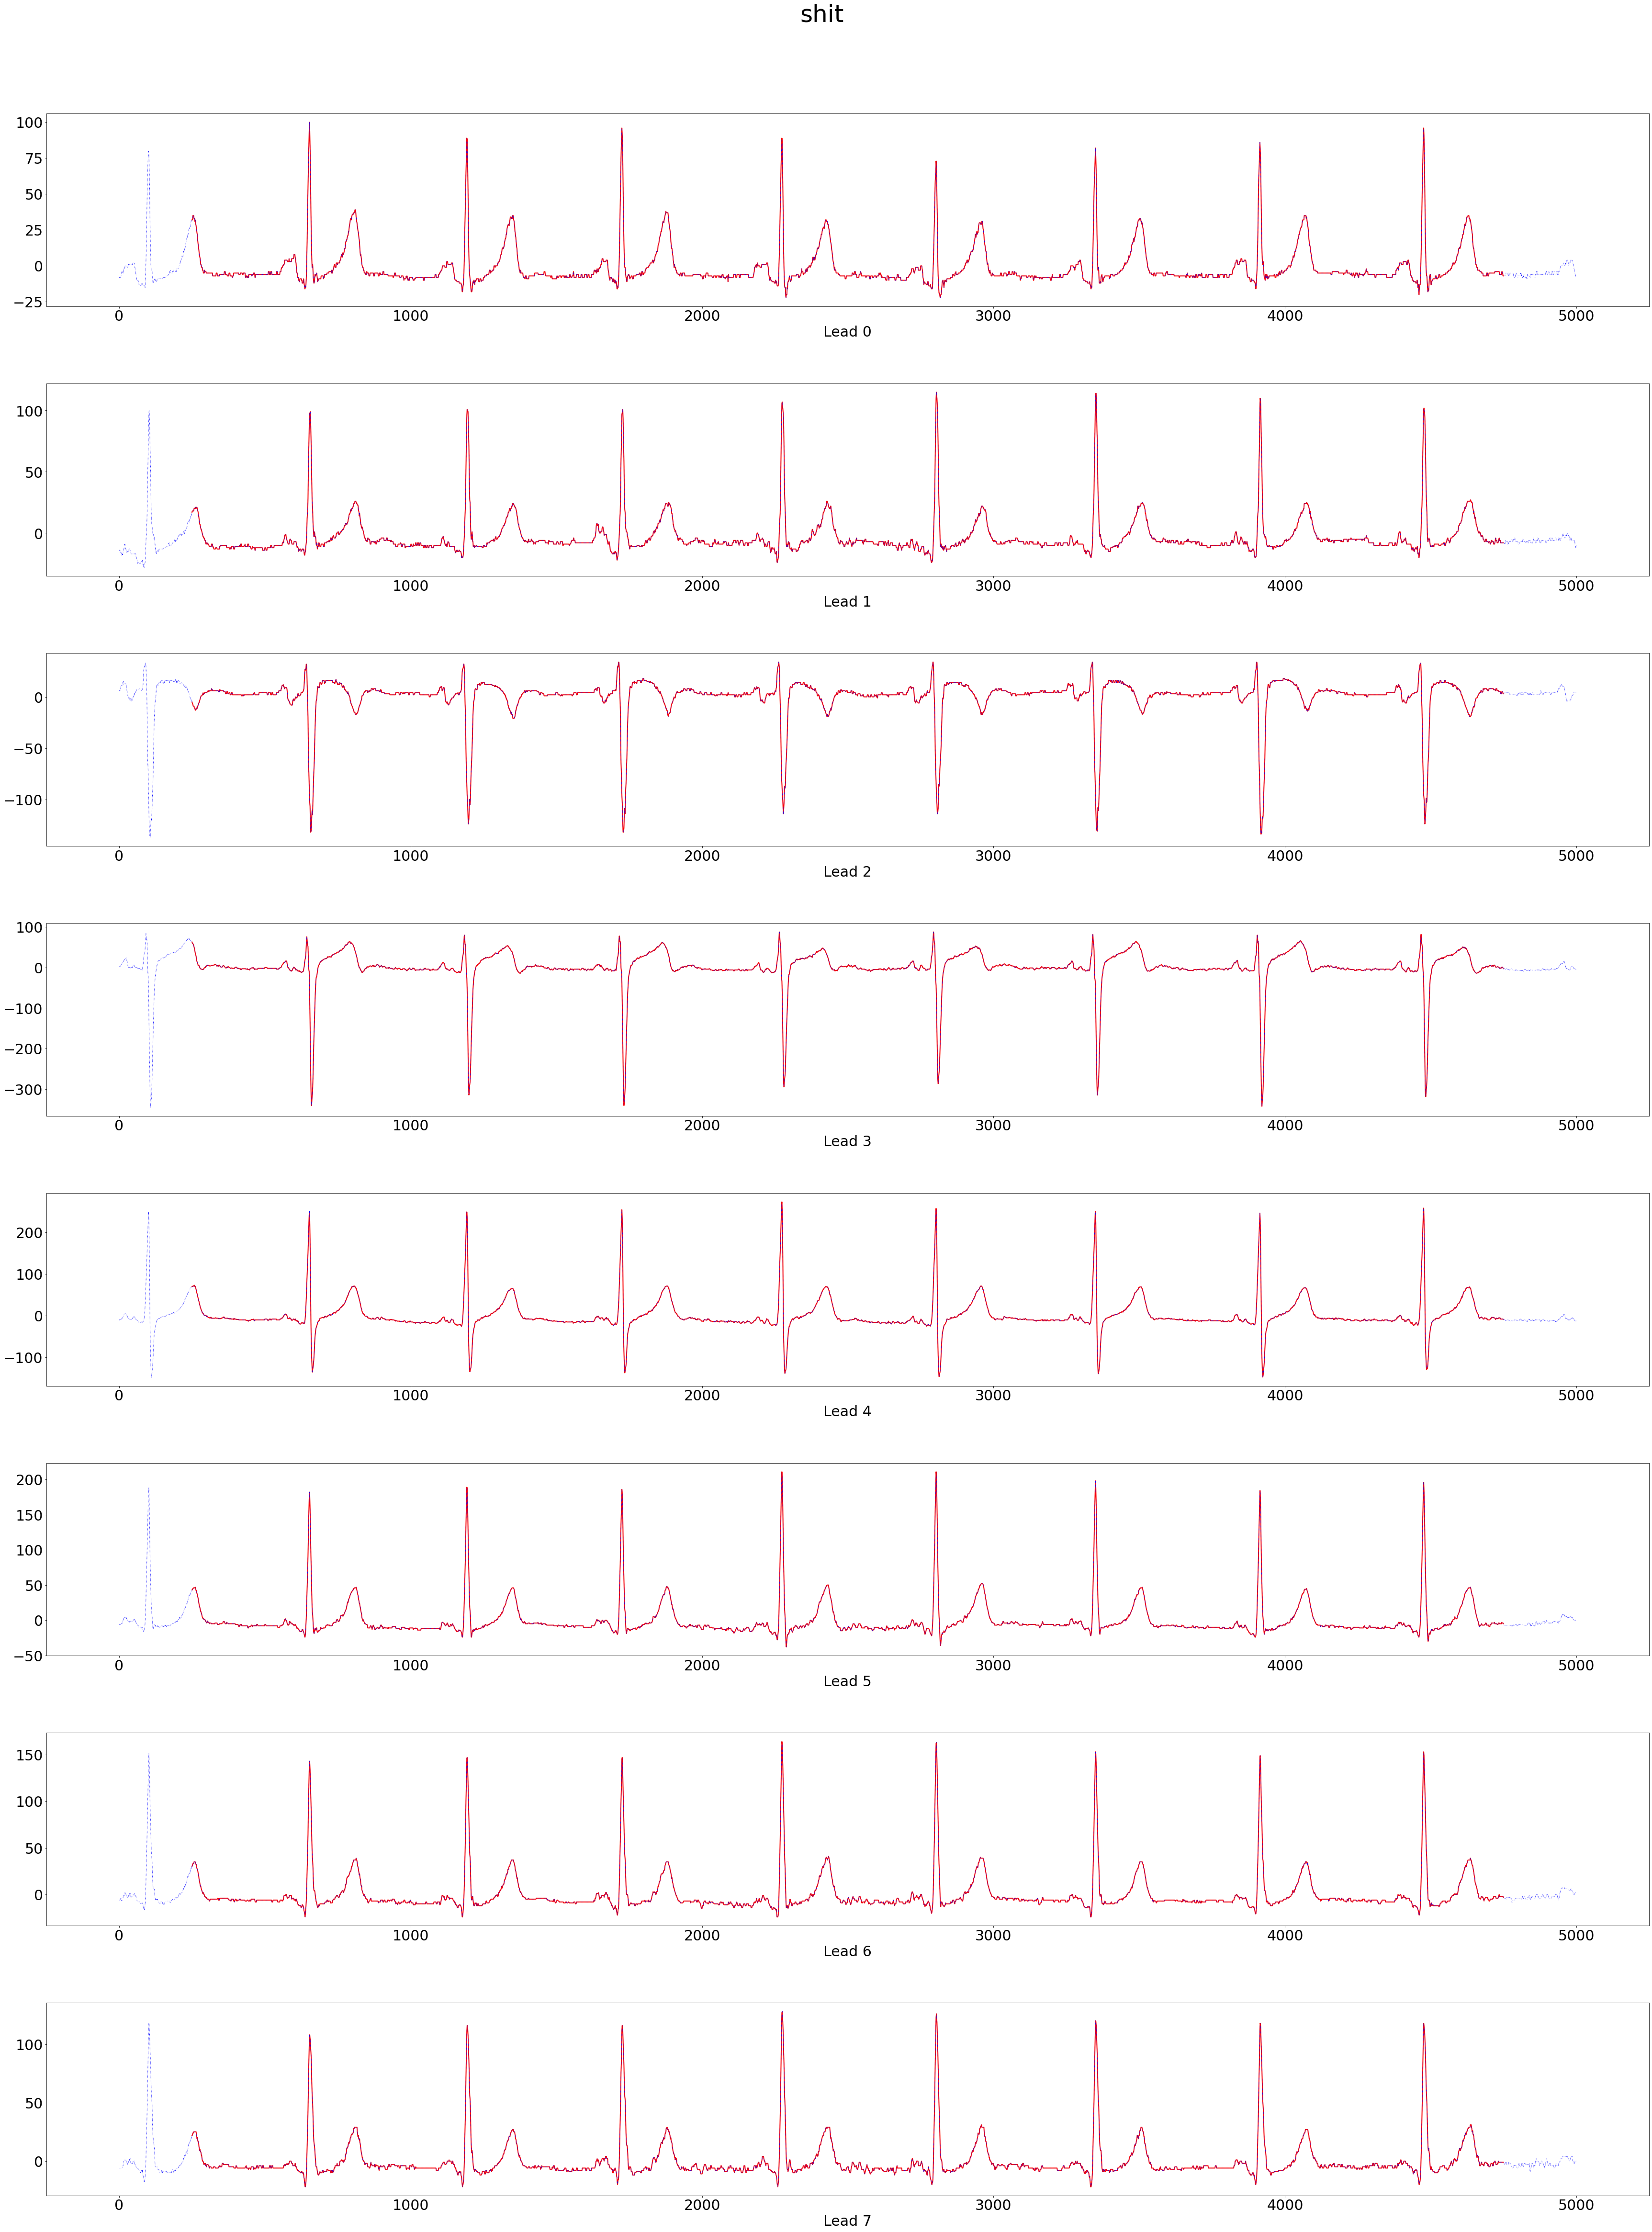

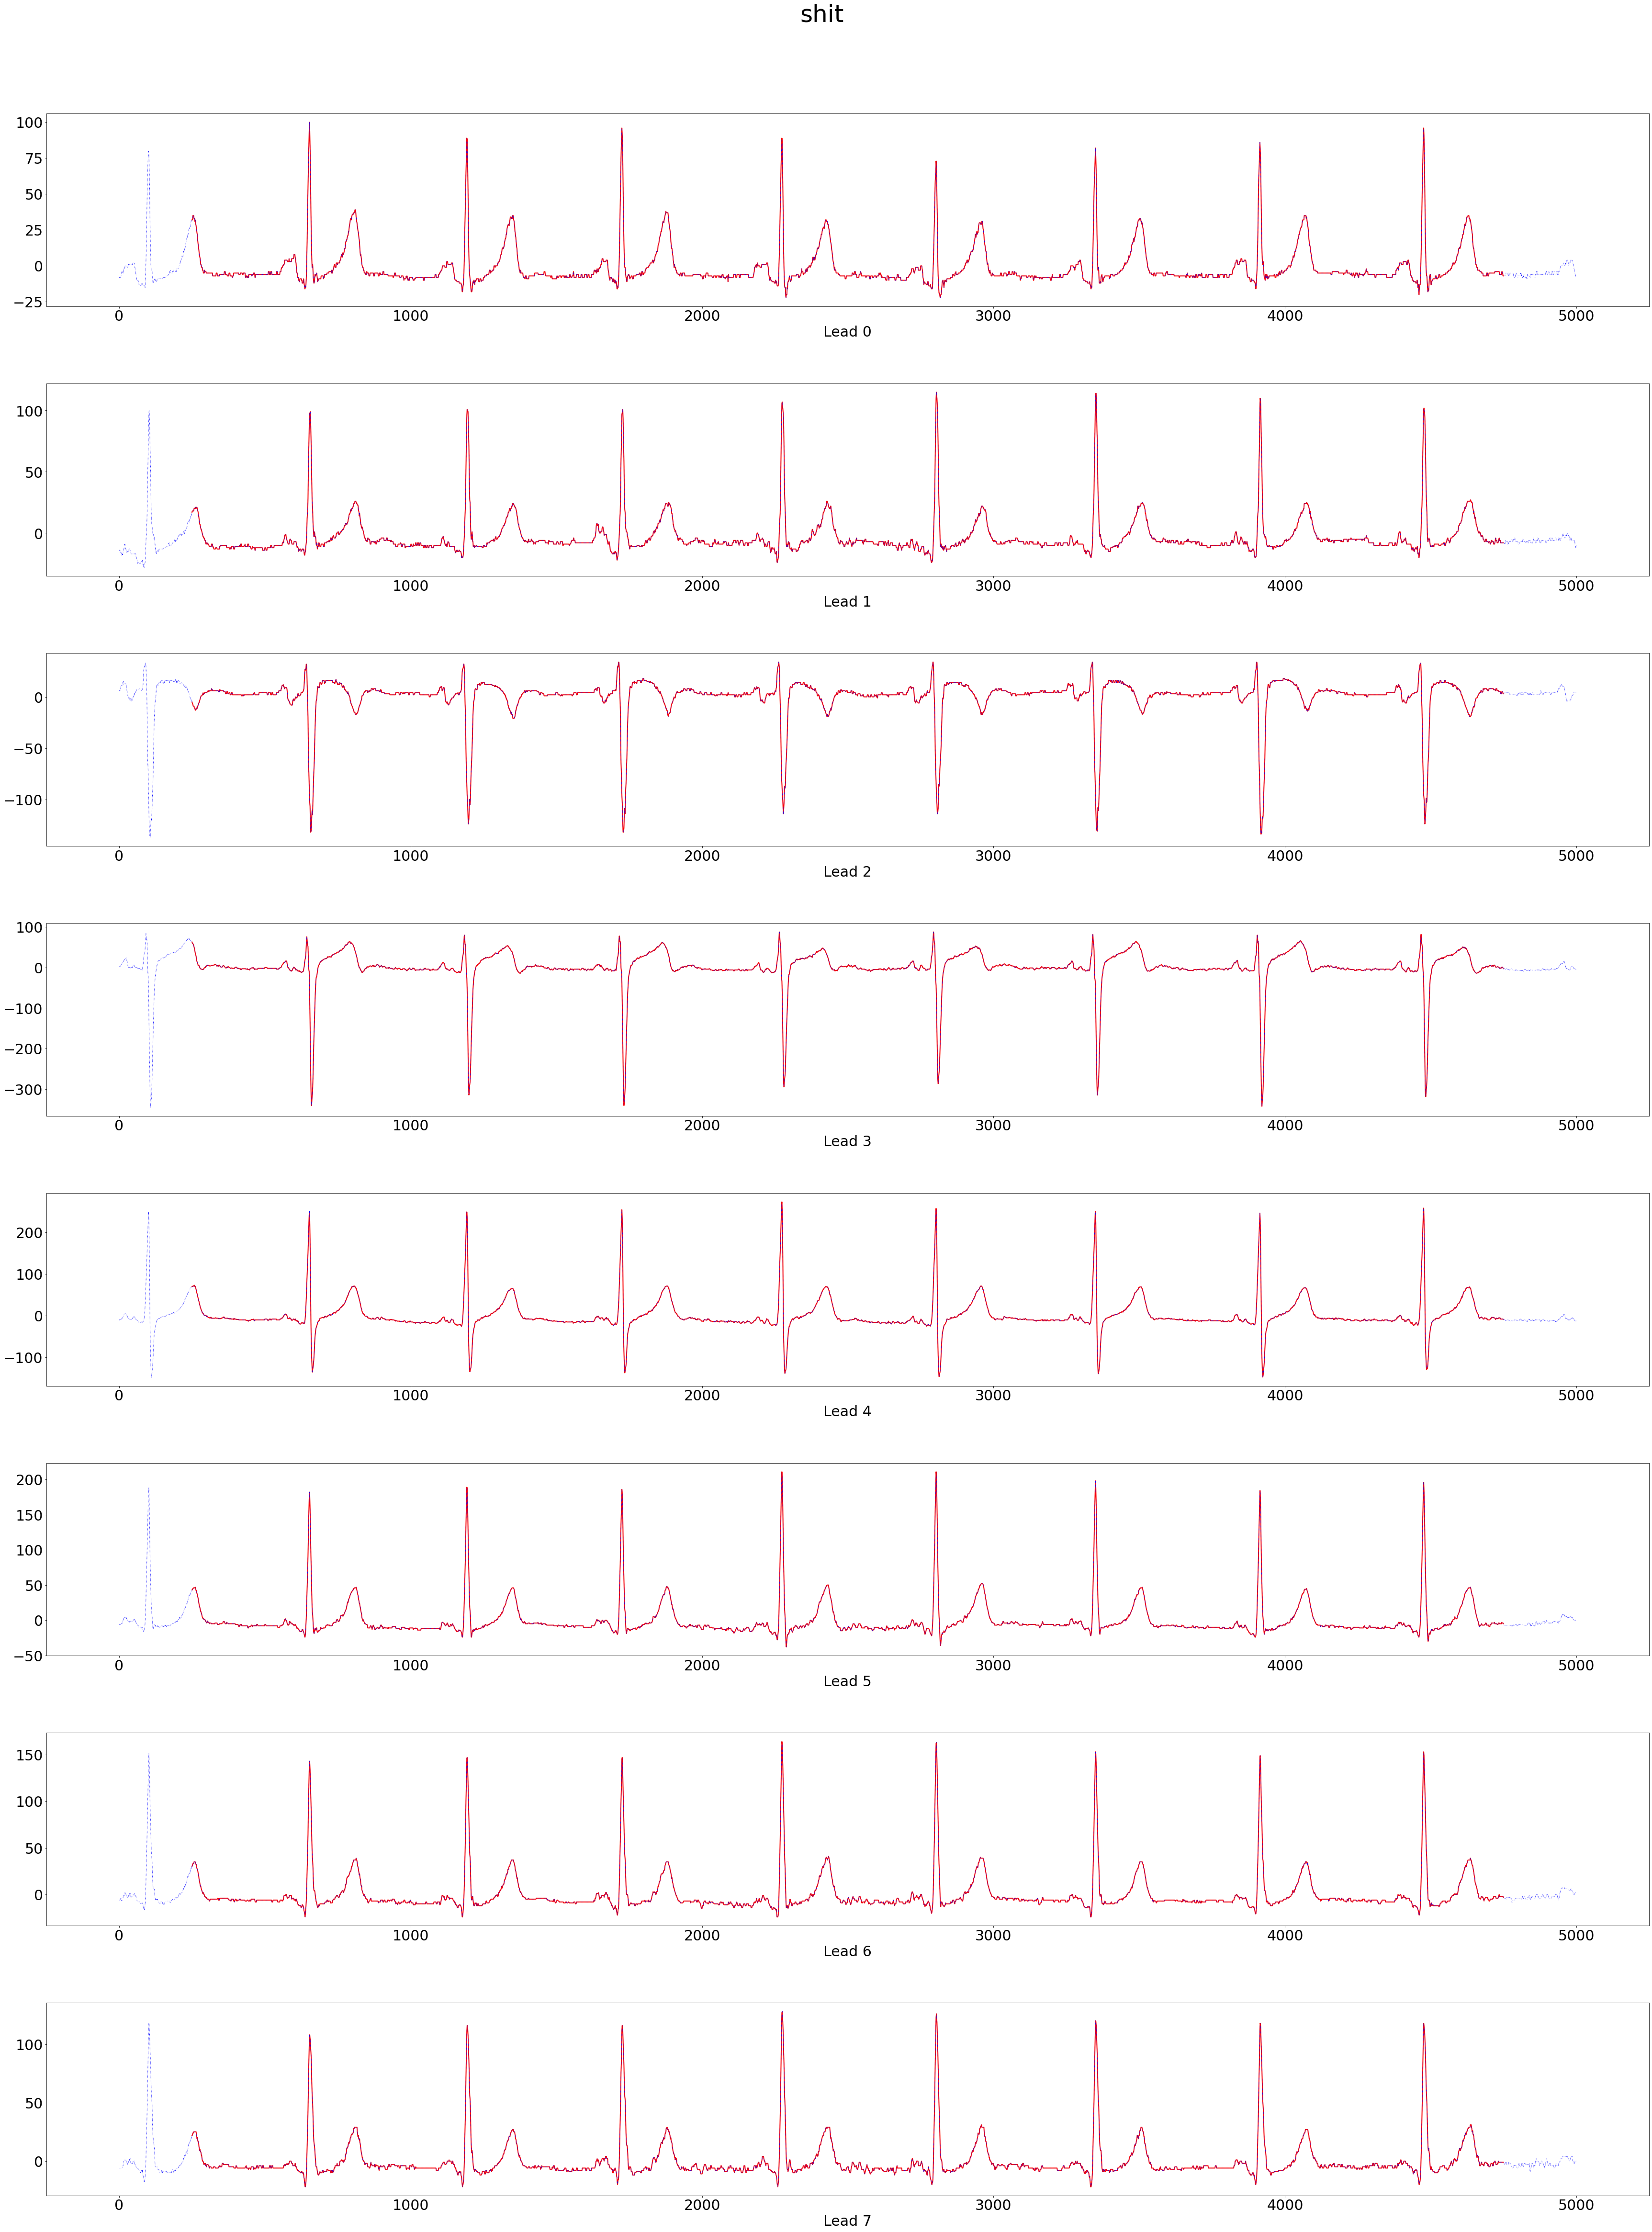

In [20]:
x = ecg[:,:, 250:4750]
visualizeLeads_comp(x.squeeze(), "shit", ecg.squeeze())

In [7]:
# Data
dataDir = '/usr/sci/cibc/Maprodxn/ClinicalECGData/LVEFCohort/pythonData/'
with open('patient_splits/pre_train_patients.pkl', 'rb') as file:
    pre_train_patients = pickle.load(file)

with open('patient_splits/validation_patients.pkl', 'rb') as file:
    validation_patients = pickle.load(file)

dataset = DataTools.ECGDatasetLoader(baseDir=dataDir,patients=pre_train_patients[:100].tolist(), normalize=False)
validation = DataTools.PatientECGDatasetLoader(baseDir=dataDir,patients=validation_patients.tolist(), normalize=False)

In [8]:
print(len(pre_train_patients), len(validation_patients), len(pre_train_patients)+len(validation_patients))

22381 2487 24868


In [9]:
pos = 0
neg = 0
for ecg, label in validation:
    if label >= 40.0:
        pos += 1
    else:
        neg += 1

print(f"Pos: {pos}, Neg: {neg}")

Pos: 2277, Neg: 210


In [15]:
def visualizeLeads(data, text, original_ecg=None):
  
  x = list(range(data.shape[-1]))
  if original_ecg is not None:
    fig, axs = plt.subplots(8, 2, figsize=(2*30, 2*8*2.5))
  else:
    fig, axs = plt.subplots(8, figsize=(2*15, 2*8*2.5))
  fig.suptitle(f'{text}', fontsize=60, y=0.92)
  for lead in range(8):
      y = list(data[lead, :])
      if original_ecg is not None:
        axs[lead, 0].plot(x,y,linewidth=2)
        axs[lead, 0].set(xlabel=f'Lead {lead} ')
        axs[lead, 0].xaxis.label.set_visible(True)

        y = list(original_ecg[lead, :])
        axs[lead, 1].plot(list(range(original_ecg.shape[-1])), y, linewidth=2)
        axs[lead, 1].set(xlabel=f'Lead {lead}')
        axs[lead, 1].xaxis.label.set_visible(True)
      else:
        axs[lead].plot(x,y,linewidth=2)
        axs[lead].set(xlabel=f'Lead {lead} ')
        axs[lead].xaxis.label.set_visible(True)

  plt.subplots_adjust(hspace=0.4, wspace=0.2)
  return fig


def visualizeLeads_comp(data, text, original_ecg):
  
  fig, axs = plt.subplots(8, figsize=(4*15, 4*8*2.5))
  fig.suptitle(f'{text}', fontsize=50, y=0.92)
  pad_size = (original_ecg.shape[-1] - data.shape[-1])//2
  if pad_size != 0:
      pad = tch.full((8, pad_size), float('nan'))
      data = tch.cat((pad, data, pad), dim=1)
  
  for lead in range(8):
        y = list(data[lead, :])
        axs[lead].plot(list(range(data.shape[-1])),y,linewidth=2, color='red')
        

        y = list(original_ecg[lead, :])
        axs[lead].plot(list(range(original_ecg.shape[-1])), y, linewidth=1, color='blue', linestyle=":")
        axs[lead].set_xlabel(f'Lead {lead}',fontsize=30)
        axs[lead].xaxis.label.set_visible(True)

        axs[lead].tick_params(axis='x', labelsize=30)  # For x-axis
        axs[lead].tick_params(axis='y', labelsize=30)  # For y-axis
      

  plt.subplots_adjust(hspace=0.4, wspace=0.2)
  return fig

In [4]:
data = dataset[50]
ecg = data[0][0]
print(data[1], ecg.shape)

tensor(64.2000) torch.Size([8, 5000])


In [33]:
augmentation = [loader.MagnitudeWarping(knots=knot, sigma=std)]
augmentation_name = str(augmentation[0].__class__.__name__)
augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

ecg = data[0][0]
mod = augs(ecg)
sig = mod[0][0]

sig.dtype

torch.float64

In [28]:
# Baseline Cubic Spline Warping
class Dummy(tch.nn.Module):
    def __init__(self, knots=10, mean=1, sigma=0.2):
        super(Dummy, self).__init__()
        self.knots = knots
        self.mean = mean
        self.sigma = sigma
    
    def forward(self, x):
        # self.std = random.uniform(self.sigma[0], self.sigma[1])
        from scipy.interpolate import CubicSpline

        self.std = self.sigma

        knot_indexes = np.linspace(0, x.shape[-1], self.knots, dtype=int)
        knot_values = np.random.normal(1, self.std, self.knots)

        spline = CubicSpline(knot_indexes, knot_values)
        self.warping = tch.tensor(spline(np.arange(x.shape[-1])))

        return x + self.warping

In [ ]:
# Gaussian Noise
np.random.seed(42)


mean = [0, 1, 10, 20]
sigma = [ 0.5, 2, 5, 10]

augmentation_list = []
for m in mean:
    for std in sigma:
        augmentation = [loader.GaussianNoise(mean=m, sigma=std)]
        augmentation_name = str(augmentation[0].__class__.__name__)
        augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

        ecg = data[0][0]
        mod = augs(ecg)
        sig = mod[0][0]

        fig, axs = plt.subplots()
        axs.plot(augmentation[0].noise)
        axs.spines['bottom'].set_color('white') 
        axs.spines['left'].set_color('white')
        fig.suptitle(f"{augmentation_name} with std:{std} mean:{m}")
        plt.show()

        temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)



In [ ]:
# Gaussian Blur
np.random.seed(42)


sigma = [ 0.5, 2, 5, 10]

augmentation_list = []
for std in sigma:
    augmentation = [loader.GaussianBlur(sigma=std)]
    augmentation_name = str(augmentation[0].__class__.__name__)
    augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

    ecg = data[0][0]
    mod = augs(ecg)
    sig = mod[0][0]

    fig, axs = plt.subplots()
    axs.plot(augmentation[0].sig[0])
    axs.spines['bottom'].set_color('white') 
    axs.spines['left'].set_color('white')
    fig.suptitle(f"{augmentation_name} with std:{std}")
    plt.show()

    temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)



In [ ]:
# Scaling
np.random.seed(42)


sigma = [ 0.2, 0.5, 1, 2]
mean = [1]

augmentation_list = []
for m in mean:
    for std in sigma:
        augmentation = [loader.Scaling(sigma=std, mean=m)]
        augmentation_name = str(augmentation[0].__class__.__name__)
        augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

        ecg = data[0][0]
        mod = augs(ecg)
        sig = mod[0][0]

        fig, axs = plt.subplots()
        axs.plot(augmentation[0].amp[0])
        axs.spines['bottom'].set_color('white') 
        axs.spines['left'].set_color('white')
        fig.suptitle(f"{augmentation_name} with std:{std} mean:{m}")
        plt.show()

        temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)



In [ ]:
# TimeWarping
np.random.seed(42)


sigma = [0.02]
knots = [2, 4, 8, 16]

augmentation_list = []
for s in sigma:
    for k in knots:
        print(f"Sigma: {s}, knots: {k}")
        augmentation = [loader.TimeWarping(sigma=s, mean=1.0, knots=k)]
        augmentation_name = str(augmentation[0].__class__.__name__)
        augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

        ecg = data[0][0]
        mod = augs(ecg)
        sig = mod[0][0]

        # fig, axs = plt.subplots()
        # axs.plot(augmentation[0].amp[0])
        # axs.spines['bottom'].set_color('white') 
        # axs.spines['left'].set_color('white')
        # fig.suptitle(f"{augmentation_name} with std:{std} mean:{m}")
        # plt.show()

        temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)



In [ ]:
# BaselineWarping
np.random.seed(42)


sigma = [10, 20, 30]
knots = [5, 10, 20]

augmentation_list = []
for s in sigma:
    for k in knots:
        print(f"Sigma: {s}, knots: {k}")
        augmentation = [loader.BaselineWarping(sigma=s, mean=10, knots=k)]
        augmentation_name = str(augmentation[0].__class__.__name__)
        augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

        ecg = data[0][0]
        mod = augs(ecg)
        sig = mod[0][0]

        # fig, axs = plt.subplots()
        # axs.plot(augmentation[0].amp[0])
        # axs.spines['bottom'].set_color('white') 
        # axs.spines['left'].set_color('white')
        # fig.suptitle(f"{augmentation_name} with std:{std} mean:{m}")
        # plt.show()

        temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)



In [ ]:
# WindowWarping
np.random.seed(42)


window_ratio = [0.1,0.33,0.5]
knots = [5, 10, 20]

augmentation_list = []
for w in window_ratio:
    augmentation = [loader.WindowWarping(window_ratio=w,scales=[0.5,2])]
    augmentation_name = str(augmentation[0].__class__.__name__)
    augs = loader.TwoCropsTransform(transforms.Compose(augmentation))

    ecg = data[0][0]
    mod = augs(ecg)
    sig = mod[0][0]

    fig, axs = plt.subplots()
    axs.plot([augmentation[0].window_starts, augmentation[0].window_ends])
    axs.spines['bottom'].set_color('white') 
    axs.spines['left'].set_color('white')
    fig.suptitle(f"{augmentation_name} with window ratio:{w}")
    
    plt.show()

    temp = visualizeLeads_comp(sig, f"RED: Added {augmentation_name}, BLUE: Original ECG", ecg)



3172 3672


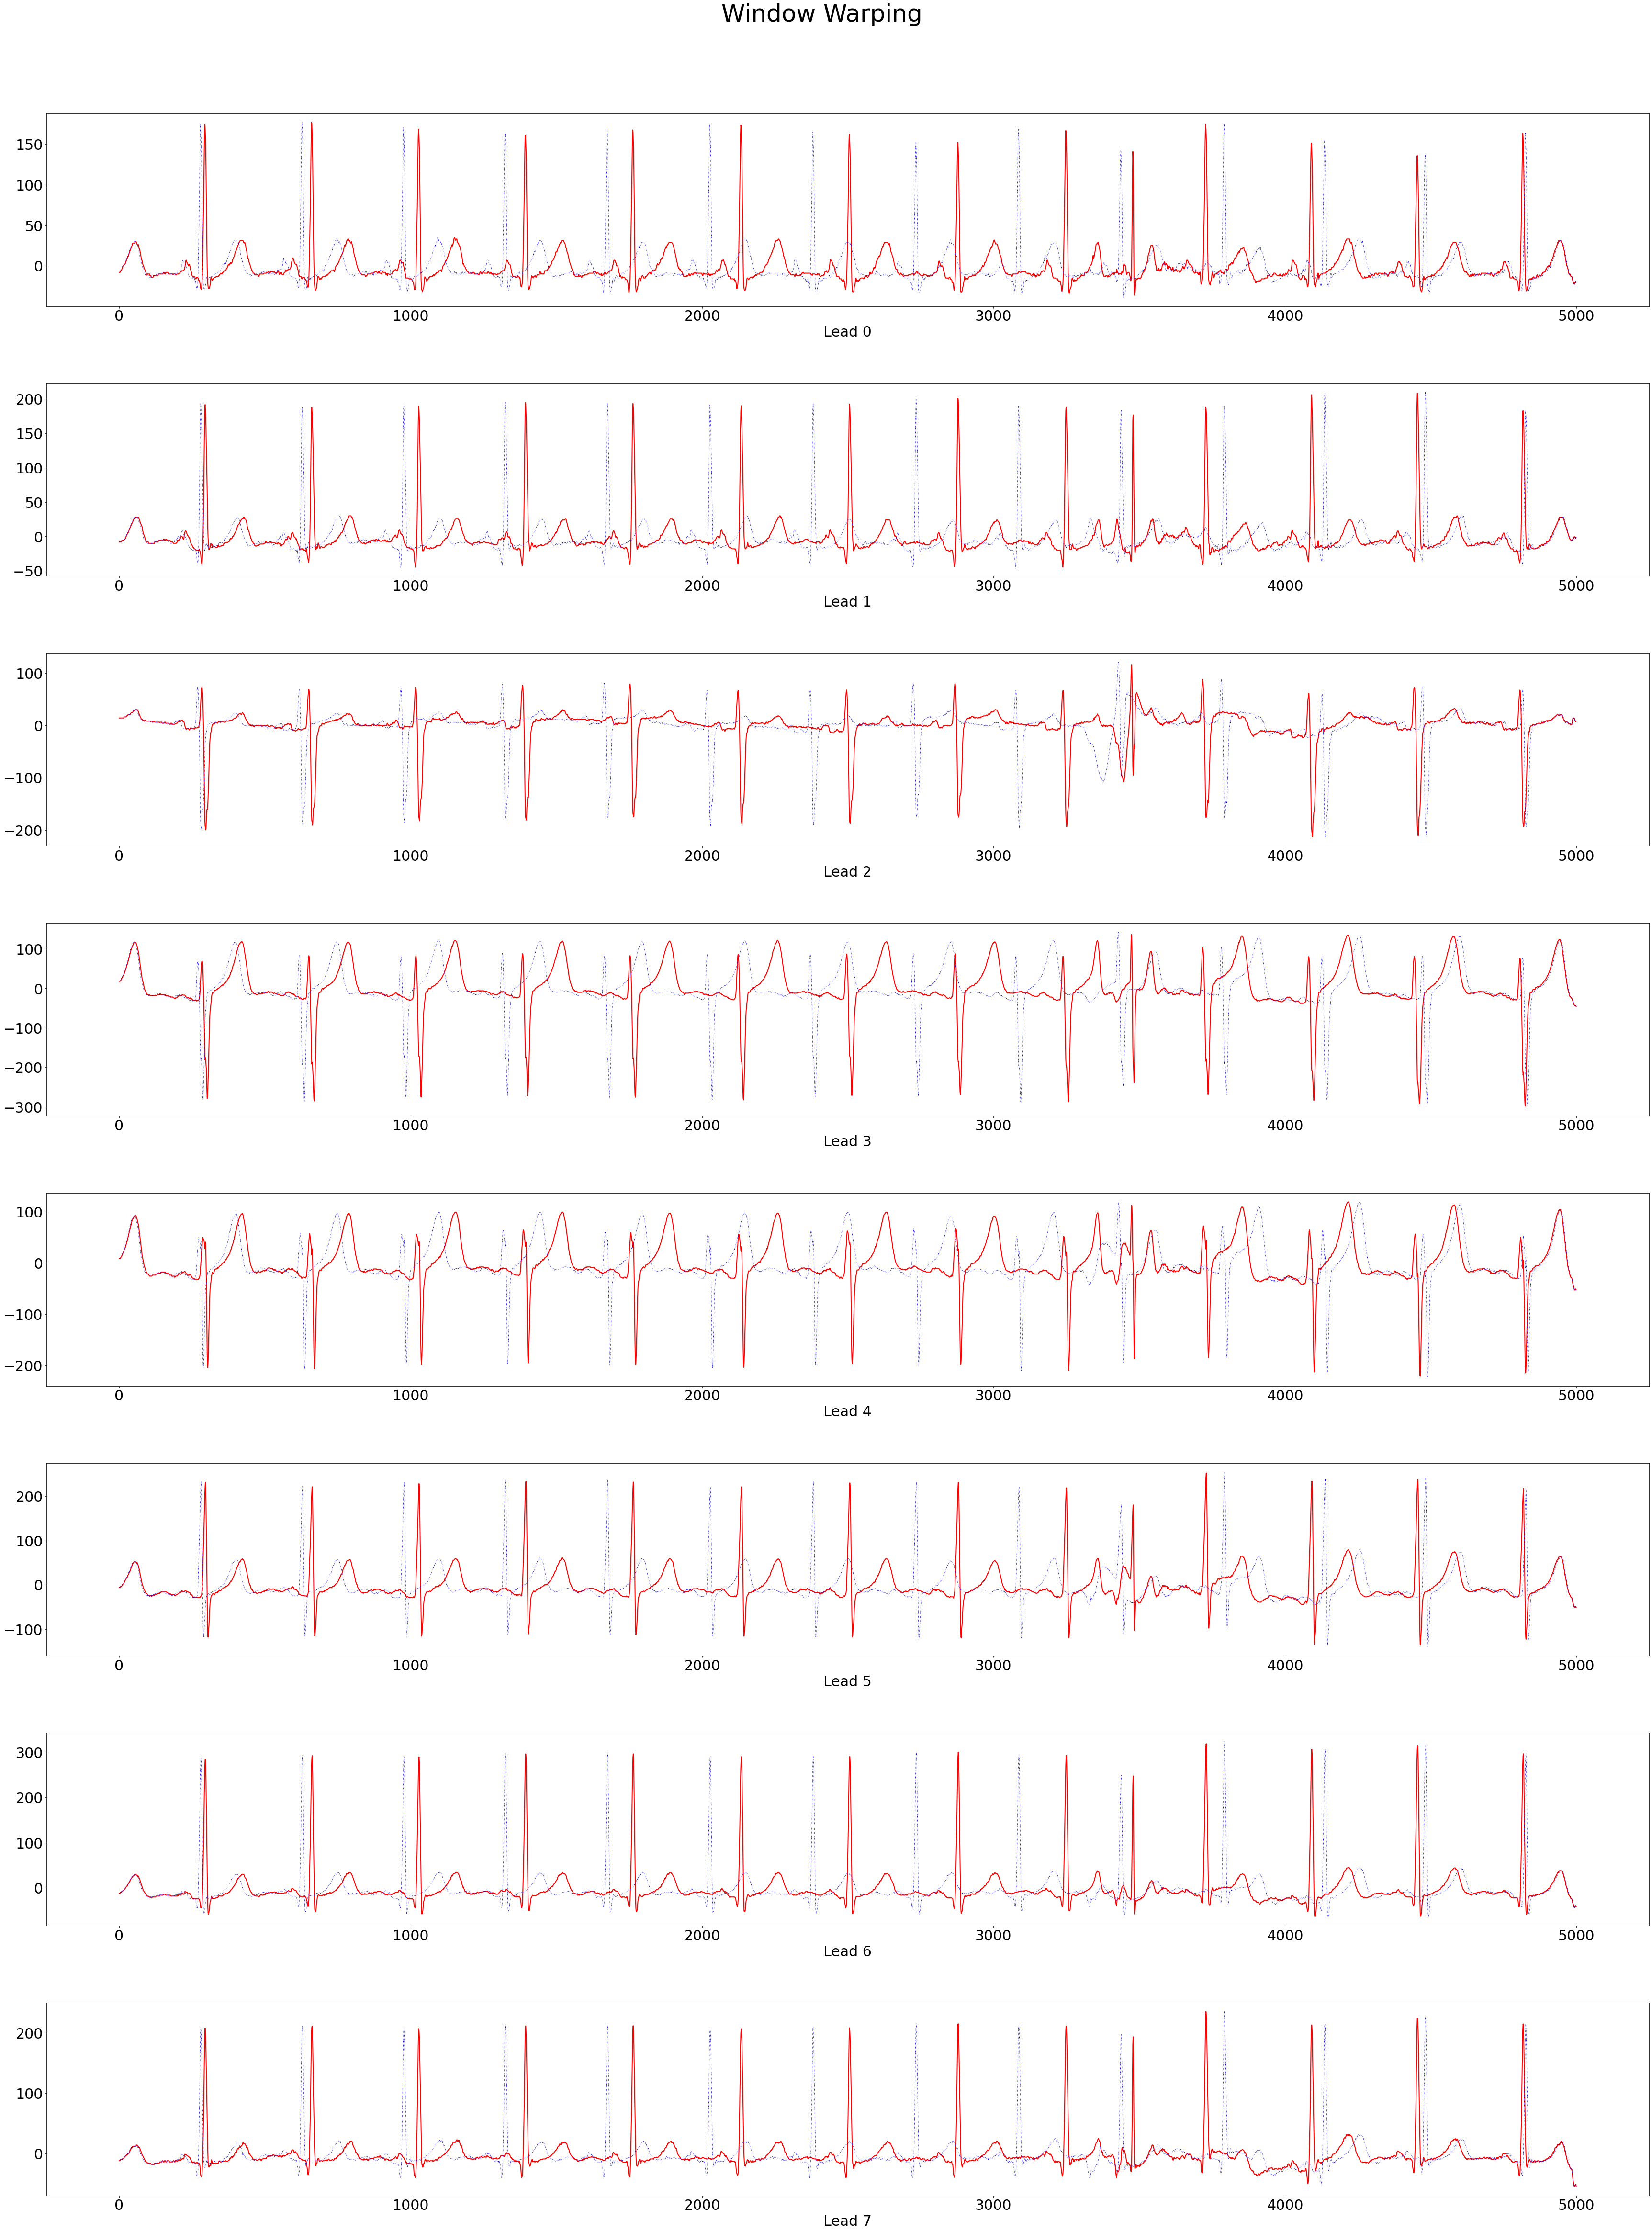

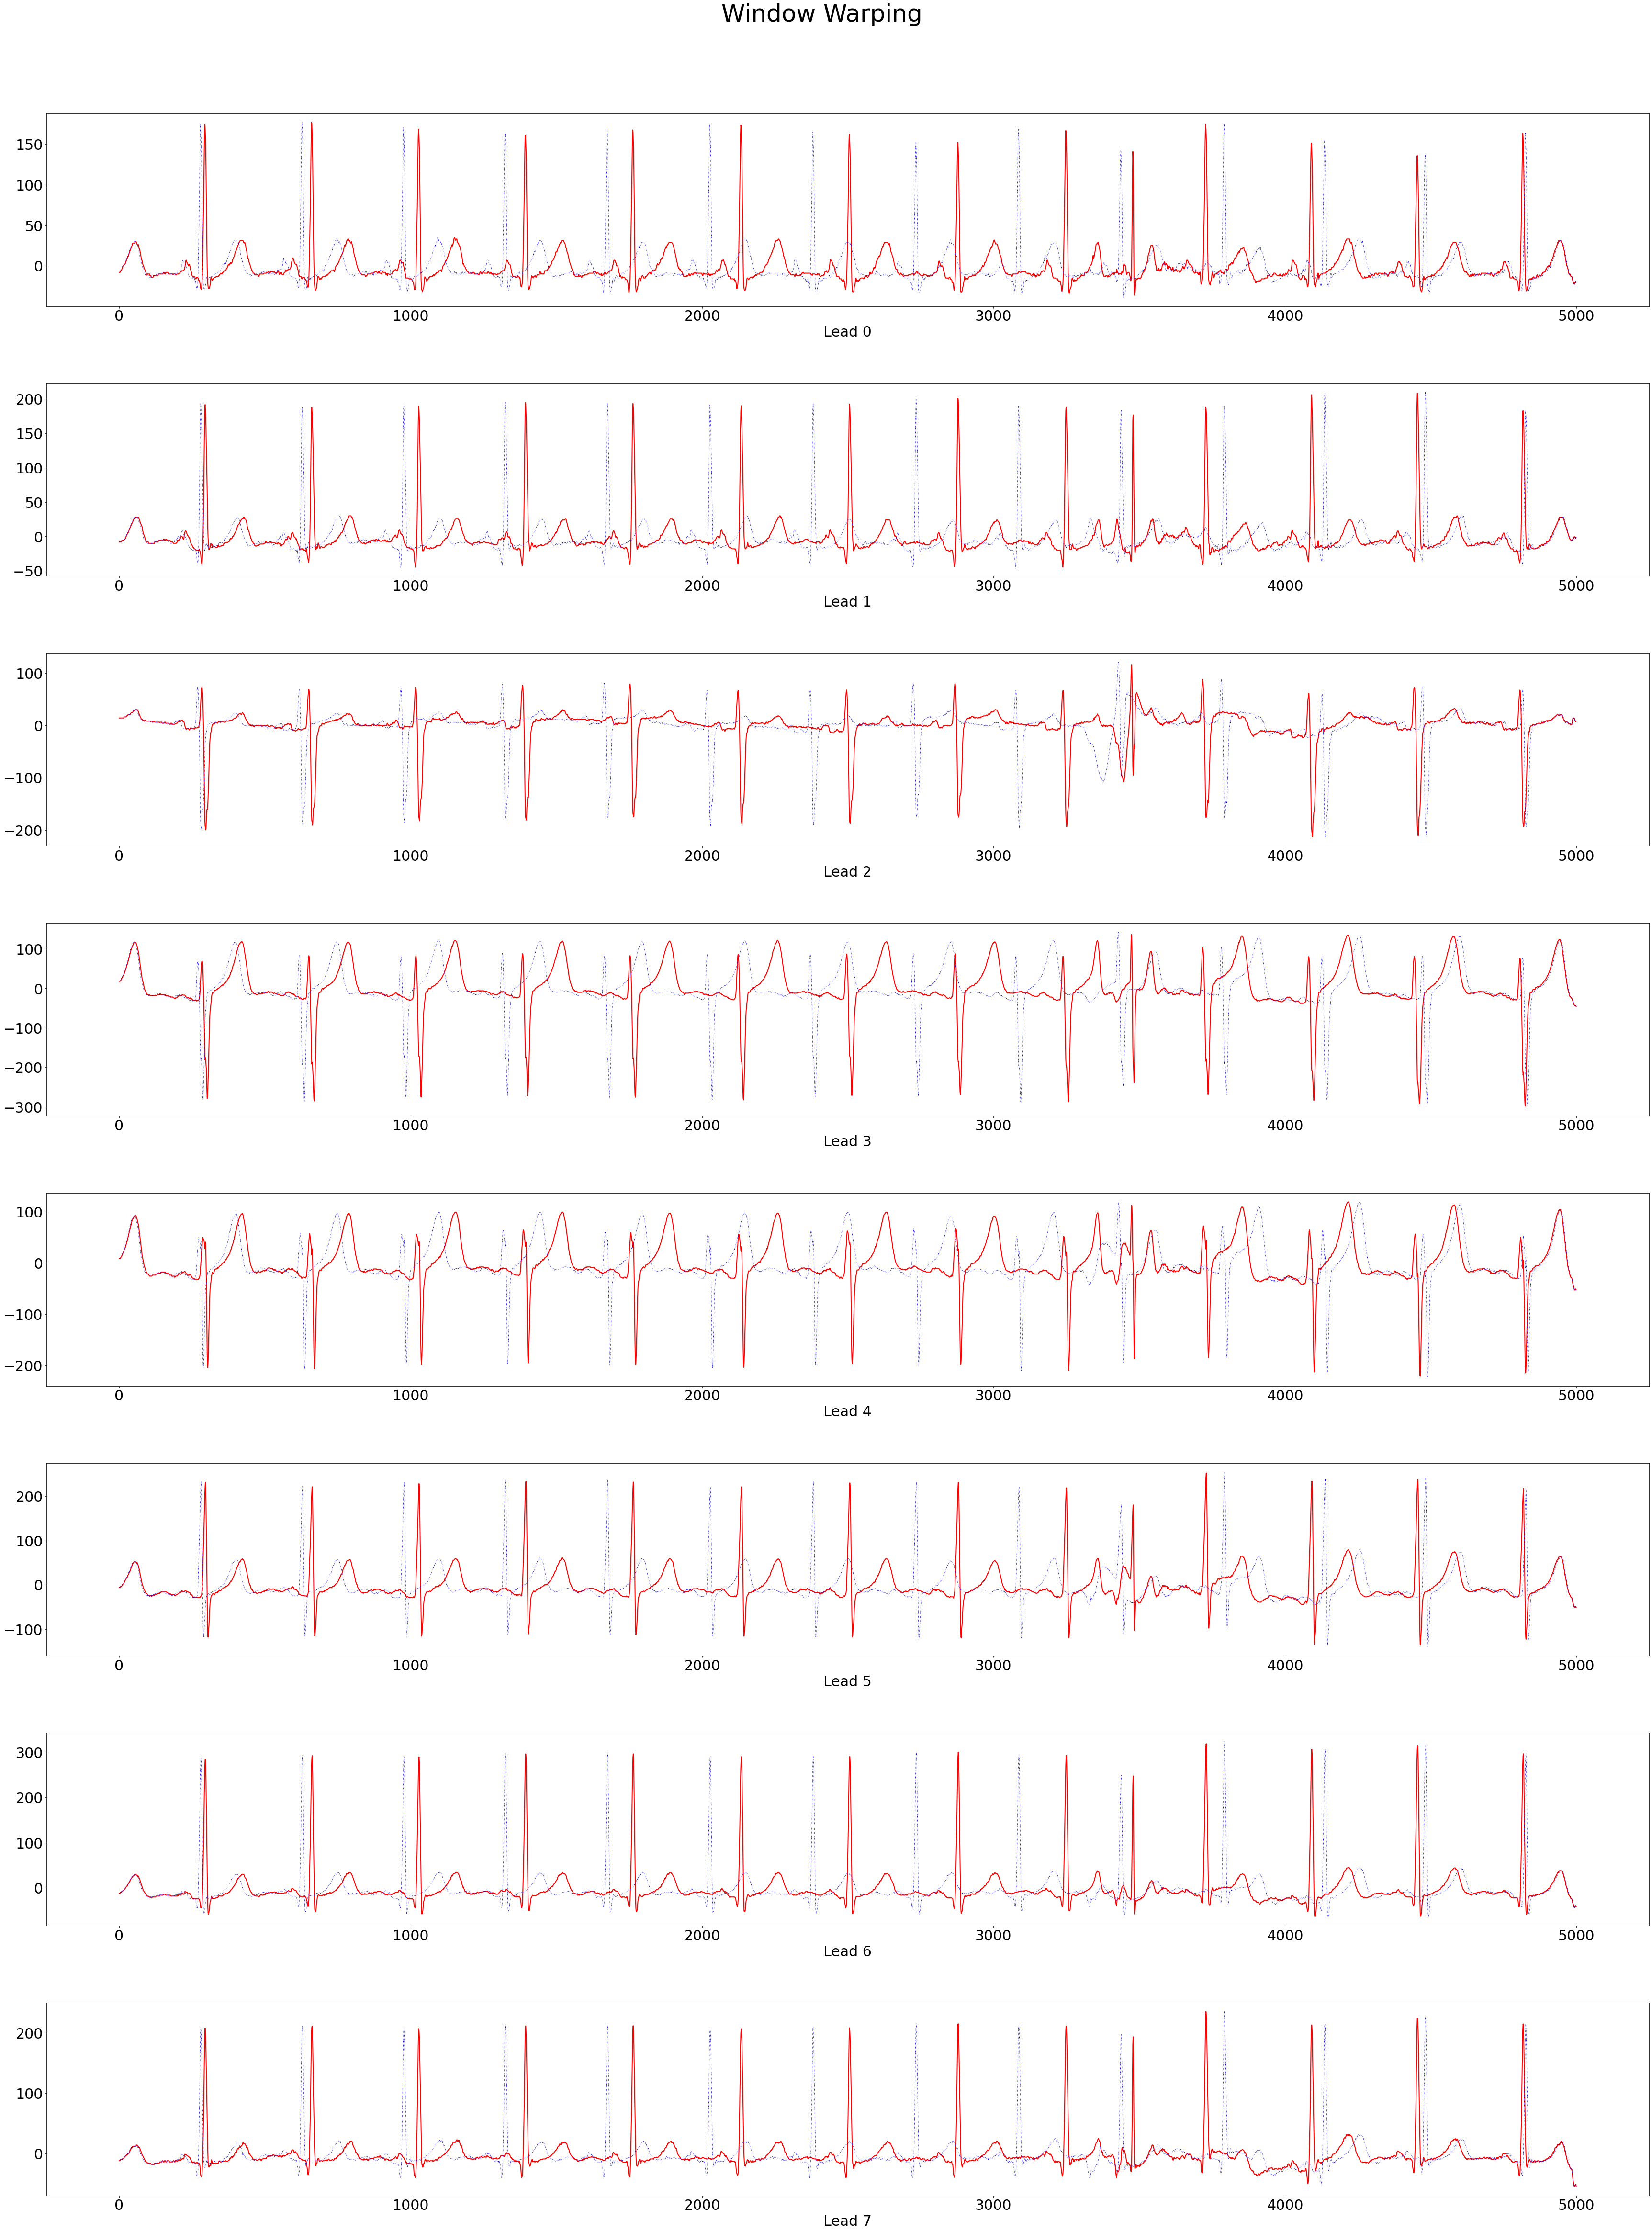

In [7]:
x = ecg
window_ratio = 0.1
scales = [0.5, 2]

warp_scale = np.random.choice(scales, 1)
warp_size = np.ceil(window_ratio*x.shape[-1]).astype(int)
window_steps = np.arange(warp_size)

window_starts = np.random.randint(low=1, high=x.shape[-1]-warp_size-1, size=1).astype(int)[0]
window_ends = (window_starts + warp_size).astype(int)
print(window_starts, window_ends)

ret = np.zeros_like(x)
for lead in range(x.shape[0]):
    start_seg = x[lead, :window_starts]
    window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scale)), window_steps, x[lead, window_starts:window_ends])
    end_seg = x[lead,window_ends:]
    warped = np.concatenate((start_seg, window_seg, end_seg))
    ret[lead, :] = np.interp(np.arange(x.shape[-1]), np.linspace(0, x.shape[-1]-1., num=warped.size), warped).T

visualizeLeads_comp(tch.tensor(ret), "Window Warping", ecg)